In [1]:
import sys
import os
import pandas as pd
from pytablewriter import MarkdownTableWriter
from typing import Dict, List, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

%config Completer.use_jedi = False


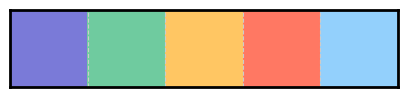

In [2]:

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.5)

plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 
                     'axes.grid': True, 'grid.linestyle': '--'})
colors = ['#7a7ad8', '#6fcb9f', '#ffc663', '#ff7863', '#93d0fc']
sns.palplot(colors)
sns.set_palette(sns.color_palette(colors), 8, .75)
sub_figure_title = {"fontweight": 700, 'fontname':'Arial', 'fontsize': 18}
#plt.tight_layout()


In [3]:
#ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance"]
ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance","afl"]

RANGE=20 #exclusive range in python


In [4]:
#path = "/home/alena/source/growe/exps8"

folder = "expfinalfinal"
base_path = f"c:\\Users\\Alena\\source\\repos\\growe\\{folder}\\"


In [5]:

def process_cov_data(path: str) -> List[str]:
    with open(path,encoding="utf8") as f:
        return f.readlines()

def add_rolling_mean( data : pd.DataFrame, rolling : int = 10) -> pd.DataFrame:
    data['valid_inputs_percent']= data['valid_inputs'] / data['total_inputs']

    # rolling mean to valid_covered_probes
    data[f'rolling_{rolling}_valid_covered_probes'] = data['valid_covered_probes'].rolling(rolling).mean()
    
    # rolling mean to all_covered_probes
    data[f'rolling_{rolling}_all_covered_probes'] = data['all_covered_probes'].rolling(rolling).mean()
    
    # rolling mean to total_inputs
    data[f'rolling_{rolling}_total_inputs'] = data['total_inputs'].rolling(rolling).mean()

    data['rolling_algorithm'] = data['algorithm'].astype(str) + f"_rollingmean_{rolling}"
    
    return data

In [6]:
def p2f(value: str) -> float:
    return float(value.strip('%'))

def read_plot_data(path: str, algorithm: str, idx: int) -> pd.DataFrame:
    ps=os.path.join(path, 'plot_data')
    #print(ps)
    time_axis = "# unix_time"
    if algorithm == "afl":
        data = pd.read_csv(ps, sep=",", skipinitialspace=True,
                       converters={"valid_cov": p2f, "map_size": p2f})
    else:
        data = pd.read_csv(ps, sep=",", skipinitialspace=True)

    if data.empty: return None

    data[time_axis] -= data[time_axis][0]
  
    if algorithm != "afl":
        data['total_inputs'] = data['valid_inputs'] + data['invalid_inputs']
        data['valid_inputs_percent']= (data['valid_inputs'] / data['total_inputs'])

    x_axis = time_axis
    algo_data = data.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    
    algo_data['algorithm'] = [algorithm] * algo_data.shape[0]
    if algorithm != "afl":
        algo_data[['generator','guidance']] = algo_data['algorithm'].str.split('-', expand=True)

    algo_data['run'] = [idx] * algo_data.shape[0]
  
    return algo_data


## READ ORIGINAL DATA

In [7]:
# READ ORIGIANL DATA

original_plot_data=[] # array of original dataframes

for algorithm in ALGORITHM:
    original_data_per_algo = []

    for idx in range(0, RANGE):
        path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
        if algorithm == "afl":
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}","fuzz-results")
        if not os.path.exists(path):
            continue
        #print(f"processing: {path}")

        # plot_data from jqf afl run differs from other 
        if os.path.exists(os.path.join(path,"plot_data")): 
            original_data = read_plot_data(path,algorithm,idx)
            if original_data is None:
                continue

            original_data_per_algo.append(original_data)
        
    original_plot_data.extend([d for d in original_data_per_algo])



In [8]:

def read_exception_log(path: str, algorithm: str) -> pd.DataFrame:
    ps=os.path.join(path, 'exception_log.csv')
    #print(ps)
    columns=["exception","unique","count","file","empty"]
    if algorithm != "afl":
        data = pd.read_csv(ps, sep=";", header=None,names=columns)

    if data.empty: return None
    
    data['algorithm'] = [algorithm] * data.shape[0]
  
    return data


In [9]:
def read_exceptions_from_jqf_log(path: str, algorithm: str) -> pd.DataFrame:
    ps=os.path.join(path, 'jqf.log')
    #print(ps)
    columns=["exception","count"]
    data={
        "exception":[]
    }
    lines = process_cov_data(ps)
    for l in lines:
        if "ERROR" in l:
            ex = l.replace("ERROR ~ ","")
            data["exception"].append(ex.split(":")[0].strip())
    #print(data)
    data = pd.DataFrame(data)
    
    if data.empty: return None
    
    data['algorithm'] = [algorithm] * data.shape[0]
  
    return data


In [10]:
# READ Exceptions

exceptions_data = []
exceptions_per_algo = []

for algorithm in ALGORITHM:
    
    for idx in range(0, RANGE):
        if not algorithm == "afl":
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
            if os.path.exists(os.path.join(path,"exception_log.csv")): 
                exc = read_exception_log(path,algorithm)
                if exc is None:
                    continue
                exc['run']= [idx] * exc.shape[0]
                exceptions_per_algo.append(exc)
        else : 
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}")
            #print(os.path.join(path,"jqf.log"))
            if os.path.exists(os.path.join(path,"jqf.log")): 
                exc = read_exceptions_from_jqf_log(path,algorithm)
                if exc is None:
                    continue
                exc['run']= [idx] * exc.shape[0]
                exceptions_per_algo.append(exc)
            
exceptions_data = pd.concat(exceptions_per_algo)



In [11]:
a = exceptions_data

pd.set_option('display.max_rows', 30)
b=a[ a['algorithm'] == 'afl']  
b

,exception,unique,count,file,empty,algorithm,run
0,Script compilation error,NaN,NaN,NaN,NaN,afl,0
1,Script compilation error,NaN,NaN,NaN,NaN,afl,0
2,Script compilation error,NaN,NaN,NaN,NaN,afl,0
3,Script compilation error,NaN,NaN,NaN,NaN,afl,0
4,Script compilation error,NaN,NaN,NaN,NaN,afl,0
...,...,...,...,...,...,...,...
4068,Script compilation error,NaN,NaN,NaN,NaN,afl,19
4069,Script compilation error,NaN,NaN,NaN,NaN,afl,19
4070,Script compilation error,NaN,NaN,NaN,NaN,afl,19
4071,Script compilation error,NaN,NaN,NaN,NaN,afl,19


## interpolated data

In [12]:
# interpolated data

reindexsteps = 6  
count_reindex_step = 120

interpolate = True

time_based_plot_data = [] #dataframe with interpolated runs 
count_based_plot_data = [] #dataframe with interpolated runs

first_idx=0
time_range=3600
for df in original_plot_data:
    algorithm = df['algorithm'][0]
    x_axis = "# unix_time"
    time_based_data = df.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    if interpolate:
        time_based_data = time_based_data.set_index(x_axis).reindex(
           range(1, time_range, reindexsteps)).interpolate().reset_index()
        #resetting algo because it was overwritten by interpolation
        time_based_data['algorithm'] = [algorithm] * time_based_data.shape[0]
        if algorithm != "afl": time_based_data[['generator','guidance']] = time_based_data['algorithm'].str.split('-', expand=True)

    if algorithm != "afl": time_based_data['valid_inputs_percent']= (time_based_data['valid_inputs'] / time_based_data['total_inputs'])

    time_based_plot_data.append( time_based_data)

    if algorithm == "afl": continue
    
    x_axis = "total_inputs"
    count_based_data = df.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    if interpolate:
        count_based_data = count_based_data.set_index(x_axis).reindex(
           range(1, count_based_data[x_axis].max(), count_reindex_step )).interpolate().reset_index()
        #resetting algo because it was overwritten by interpolation
        count_based_data['algorithm'] = [algorithm] * count_based_data.shape[0]
        if algorithm != "afl": count_based_data[['generator','guidance']] = count_based_data['algorithm'].str.split('-', expand=True)
        
    count_based_data['valid_inputs_percent']= (count_based_data['valid_inputs'] / count_based_data['total_inputs'])
    
    count_based_plot_data.append(count_based_data)

    
    first_idx = first_idx +1
#
time_based_plot_data = pd.concat(time_based_plot_data, ignore_index=True, sort=False)
count_based_plot_data = pd.concat(count_based_plot_data, ignore_index=True, sort=False)
afl_time_based_plot_data = time_based_plot_data[time_based_plot_data['algorithm']=='afl']
time_based_plot_data = time_based_plot_data[time_based_plot_data['algorithm']!='afl']


In [13]:
time_based_plot_data


,# unix_time,cycles_done,cur_path,paths_total,pending_total,pending_favs,map_size,unique_crashes,unique_hangs,max_depth,...,invalid_inputs,valid_cov,all_covered_probes,valid_covered_probes,total_inputs,valid_inputs_percent,algorithm,generator,guidance,run
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,semantic,zest,NaN
1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,semantic,zest,NaN
2,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,semantic,zest,NaN
3,19,0.0,0.0,22.0,0.0,0.0,7985.550,1.0,0.0,0.0,...,16.0,7653.910,20443.0,19594.0,41.0,0.609756,semantic-zest,semantic,zest,0.0
4,25,0.0,0.0,26.0,0.0,0.0,8083.595,1.5,0.0,0.0,...,20.0,7751.955,20694.0,19845.0,56.5,0.646018,semantic-zest,semantic,zest,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,3571,0.0,0.0,30.0,0.0,0.0,6823.830,1489.0,0.0,0.0,...,7829.0,6544.920,17469.0,16755.0,15896.0,0.507486,syntactic-noguidance,syntactic,noguidance,19.0
47996,3577,0.0,0.0,30.0,0.0,0.0,6823.830,1491.0,0.0,0.0,...,7835.0,6544.920,17469.0,16755.0,15906.0,0.507419,syntactic-noguidance,syntactic,noguidance,19.0
47997,3583,0.0,0.0,30.0,0.0,0.0,6823.830,1492.0,0.0,0.0,...,7839.0,6544.920,17469.0,16755.0,15912.5,0.507368,syntactic-noguidance,syntactic,noguidance,19.0
47998,3589,0.0,0.0,30.0,0.0,0.0,6823.830,1493.0,0.0,0.0,...,7843.0,6544.920,17469.0,16755.0,15919.0,0.507318,syntactic-noguidance,syntactic,noguidance,19.0


## rolling mean data

In [14]:
# rolling mean data

ROLLING_MEAN=50

rolling_time_based_plot_data = [] #dataframe with rolling mean over all runs
rolling_count_based_plot_data = [] #dataframe with rolling mean over all runs

complete_data_frame = pd.concat(original_plot_data, ignore_index=True, sort=False)
for algorithm in ALGORITHM:
    data_per_algo = complete_data_frame[complete_data_frame['algorithm'] == algorithm]

    if data_per_algo is None or len(data_per_algo) == 0: continue

    rolling_time_based_data_per_algo = data_per_algo.sort_values(by=['# unix_time'])
    rolling_time_based_data_per_algo = add_rolling_mean(rolling_time_based_data_per_algo, ROLLING_MEAN)
    rolling_time_based_plot_data.append(rolling_time_based_data_per_algo)

    rolling_count_based_data_per_algo = data_per_algo.sort_values(by=['total_inputs'])
    rolling_count_based_data_per_algo = add_rolling_mean(rolling_count_based_data_per_algo, ROLLING_MEAN)
    rolling_count_based_plot_data.append(rolling_count_based_data_per_algo)



 
rolling_time_based_plot_data = pd.concat(rolling_time_based_plot_data, ignore_index=True, sort=True)
rolling_count_based_plot_data = pd.concat(rolling_count_based_plot_data, ignore_index=True, sort=True)



In [15]:
complete_data_frame


,# unix_time,cycles_done,cur_path,paths_total,pending_total,pending_favs,map_size,unique_crashes,unique_hangs,max_depth,...,invalid_inputs,valid_cov,all_covered_probes,valid_covered_probes,total_inputs,valid_inputs_percent,algorithm,generator,guidance,run
0,0,0,0,1,0,0,755.47,0,0,0,...,0.0,755.47,1934.0,1934.0,1.0,1.000000,semantic-zest,semantic,zest,0
1,11,0,0,12,0,0,7666.41,0,0,0,...,7.0,7342.97,19626.0,18798.0,19.0,0.631579,semantic-zest,semantic,zest,0
2,15,0,0,16,0,0,7692.19,1,0,0,...,10.0,7349.22,19692.0,18814.0,27.0,0.629630,semantic-zest,semantic,zest,0
3,19,0,0,22,0,0,7985.55,1,0,0,...,16.0,7653.91,20443.0,19594.0,41.0,0.609756,semantic-zest,semantic,zest,0
4,23,0,0,25,0,0,8181.64,1,0,0,...,16.0,7850.00,20945.0,20096.0,48.0,0.666667,semantic-zest,semantic,zest,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119225,581,0,4,12,11,1,3.47,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,afl,NaN,NaN,19
119226,1165,0,5,12,10,0,3.47,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,afl,NaN,NaN,19
119227,1953,0,5,13,11,0,3.47,0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,afl,NaN,NaN,19
119228,2145,0,10,13,10,0,3.47,0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,afl,NaN,NaN,19


In [16]:
def generate_plot_data_base(data: pd.DataFrame, rolling_data:pd.DataFrame, x_axis: str, y_axis: str, path: str, errorbarname: str = 'se'):
    print(x_axis, y_axis)
    fig, ax1 = plt.subplots(figsize=(8,5))
    #ax2 = ax1.twinx()

    lineplot1 = sns.lineplot(x=x_axis, y=y_axis, hue='algorithm', errorbar="ci", hue_order=sorted(data['algorithm'].unique()), data=data, ax=ax1)    
    '''
    y2=f"rolling_{ROLLING_MEAN}_{y_axis}"
    if not y2 in rolling_data.columns:
        y2 = y_axis
    
    lineplot2 = sns.lineplot(x=x_axis, 
                             y=y2, 
                             hue='rolling_algorithm', 
                             errorbar=None, 
                             hue_order=sorted(rolling_data['rolling_algorithm'].unique()), 
                             data=rolling_data, 
                             ax=ax1, 
                             palette="Set2",
                             linestyle="dotted")
    legend2 = lineplot2.legend()

    leg_lines = legend2.get_lines()
    for line in leg_lines[4:]:
        line.set_linestyle(":")
    '''
        
    ax1.set_xlabel(x_axis)
    ax1.set_ylabel(y_axis)
    
    lineplot1.set(title=path.split("/")[-1][:-4].replace("_"," "))
   
    # ax2.set_ylabel(f"rolling_{ROLLING_MEAN}_{y_axis}")

    fig = ax1.get_figure()
    fig.show()
    fig.savefig(path, bbox_inches = 'tight', pad_inches = 0.1)

In [17]:
errorbrar = 'se'
pdf_dir=f'pdfs_{folder}/'

if not os.path.exists(os.path.join(".",pdf_dir)):
    os.mkdir(os.path.join(".",pdf_dir))

    

# unix_time valid_covered_probes


C:\Users\Alena\AppData\Local\Temp\ipykernel_15812\2338042562.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


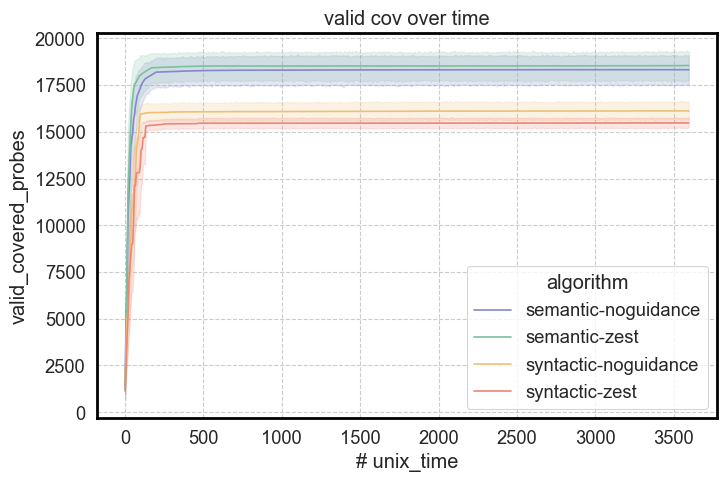

In [18]:
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_covered_probes", f"{pdf_dir}valid_cov_over_time.pdf", 'ci')


# unix_time all_covered_probes


C:\Users\Alena\AppData\Local\Temp\ipykernel_15812\2338042562.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


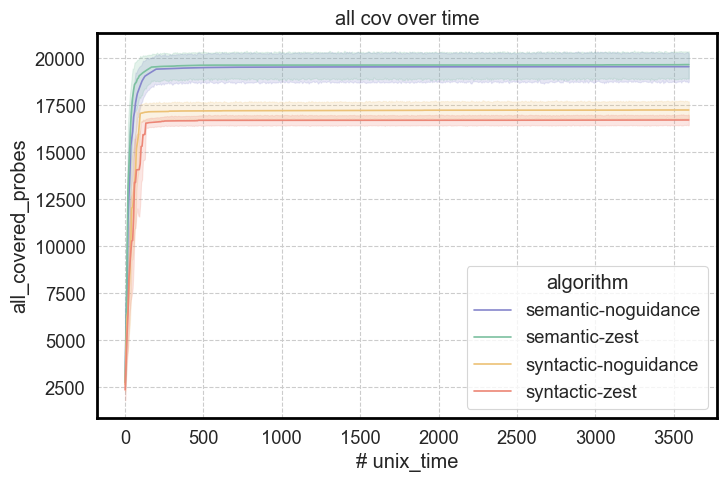

In [19]:
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "all_covered_probes", f"{pdf_dir}all_cov_over_time.pdf", 'ci')


(-178.70000000000002, 3774.7)
(-178.70000000000002, 3774.7)


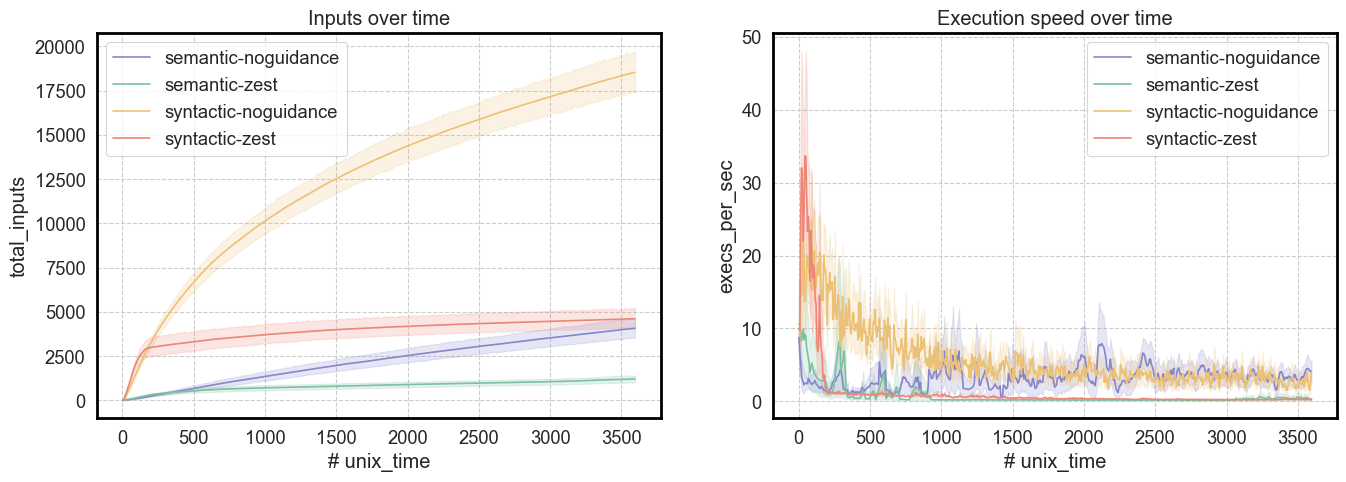

In [20]:
fig, ax1 = plt.subplots(1,2,figsize=(16,5))
x='# unix_time'
lineplot1 = sns.lineplot(x=x, y='total_inputs', hue='algorithm', errorbar="ci", hue_order=sorted(time_based_plot_data['algorithm'].unique()), data=time_based_plot_data, ax=ax1[0])
lineplot1.set_title("Inputs over time")
lineplot1.legend(loc='upper left')
lineplot2 = sns.lineplot(x=x, 
                         y='execs_per_sec', 
                         hue='algorithm', 
                         errorbar="ci", 
                         hue_order=sorted(time_based_plot_data['algorithm'].unique()), 
                         data=time_based_plot_data, 
                         ax=ax1[1])
lineplot2.set_title("Execution speed over time")
lineplot2.legend(loc='upper right')

print(lineplot1.get_xlim())
print(lineplot2.get_xlim())
path=f"{pdf_dir}/inputs_and_speed_over_time.pdf"

fig.savefig(path, bbox_inches = 'tight', pad_inches = 0.1)

In [21]:
time_based_plot_data.groupby(['algorithm'])['execs_per_sec'].describe()


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
semantic-noguidance,11911.0,3.227114,5.037300,0.02,0.415917,1.0700,4.169286,63.33
semantic-zest,11921.0,0.721048,3.890049,0.03,0.140000,0.1805,0.257500,93.55
syntactic-noguidance,11991.0,5.661995,6.823508,0.03,1.530000,3.2200,7.015000,99.01
syntactic-zest,11985.0,1.356752,6.126536,0.03,0.260000,0.3950,0.670000,142.56


# unix_time total_inputs


C:\Users\Alena\AppData\Local\Temp\ipykernel_15812\2338042562.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


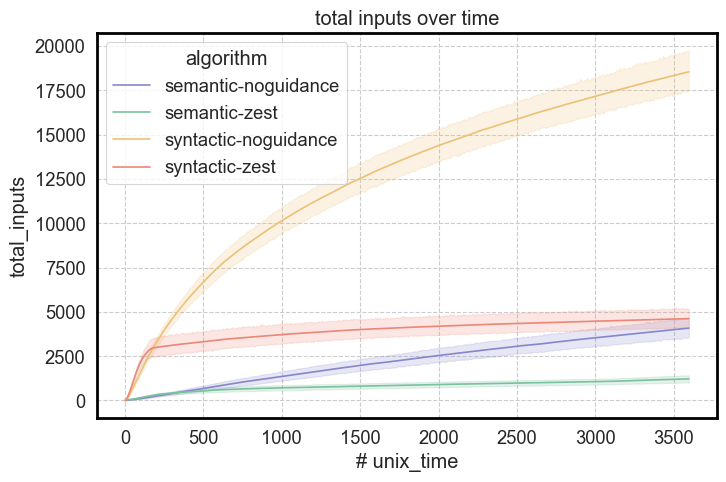

In [22]:
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "total_inputs", f"{pdf_dir}total_inputs_over_time.pdf", 'se')


# unix_time execs_per_sec


C:\Users\Alena\AppData\Local\Temp\ipykernel_15812\2338042562.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


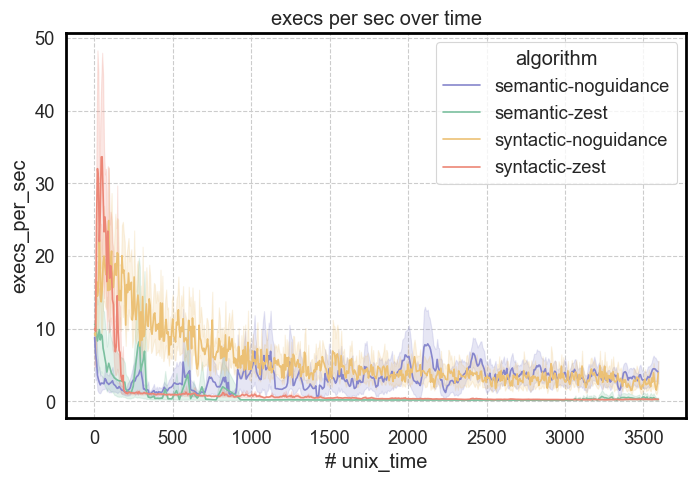

In [23]:
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "execs_per_sec", f"{pdf_dir}execs_per_sec_over_time.pdf", 'se')


In [24]:
complete_data_frame.groupby(['algorithm','run'])['total_inputs'].last().groupby(['algorithm']).mean()

algorithm
afl                          NaN
semantic-noguidance      4091.35
semantic-zest            1224.75
syntactic-noguidance    18550.00
syntactic-zest           4619.20
Name: total_inputs, dtype: float64

In [25]:
time_based_plot_data.groupby(['run','algorithm'])['execs_per_sec'].mean()

run   algorithm           
0.0   semantic-noguidance     3.979318
      semantic-zest           0.736139
      syntactic-noguidance    7.734408
      syntactic-zest          2.223013
1.0   semantic-noguidance     3.123646
                                ...   
18.0  syntactic-zest          1.308447
19.0  semantic-noguidance     4.034200
      semantic-zest           0.182851
      syntactic-noguidance    4.703175
      syntactic-zest          1.421325
Name: execs_per_sec, Length: 80, dtype: float64

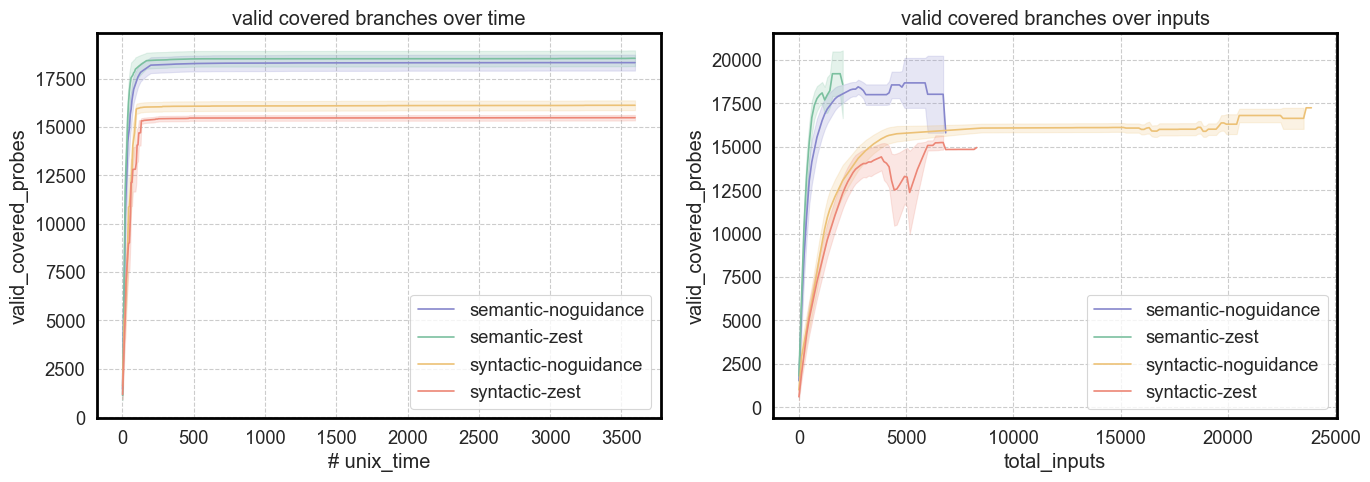

In [26]:
fig, ax1 = plt.subplots(1,2,figsize=(16,5))
x='# unix_time'
lineplot1 = sns.lineplot(x=x, y='valid_covered_probes', 
                         hue='algorithm',
                         errorbar="se",
                         hue_order=sorted(time_based_plot_data['algorithm'].unique()), 
                         data=time_based_plot_data, 
                         ax=ax1[0])
lineplot1.set_title("valid covered branches over time")
lineplot1.legend(loc='lower right')
x2='total_inputs'
lineplot2 = sns.lineplot(x=x2, 
                         y='valid_covered_probes', 
                         hue='algorithm', 
                         hue_order=sorted(count_based_plot_data['algorithm'].unique()), 
                         errorbar="se",
                         data=count_based_plot_data, 
                         ax=ax1[1])
lineplot2.set_title("valid covered branches over inputs")
lineplot2.legend(loc='lower right')

path=f"{pdf_dir}/covered_probes_time_and_inputs.pdf"


fig.savefig(path, bbox_inches = 'tight', pad_inches = 0.1)

total_inputs valid_covered_probes


C:\Users\Alena\AppData\Local\Temp\ipykernel_15812\2338042562.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


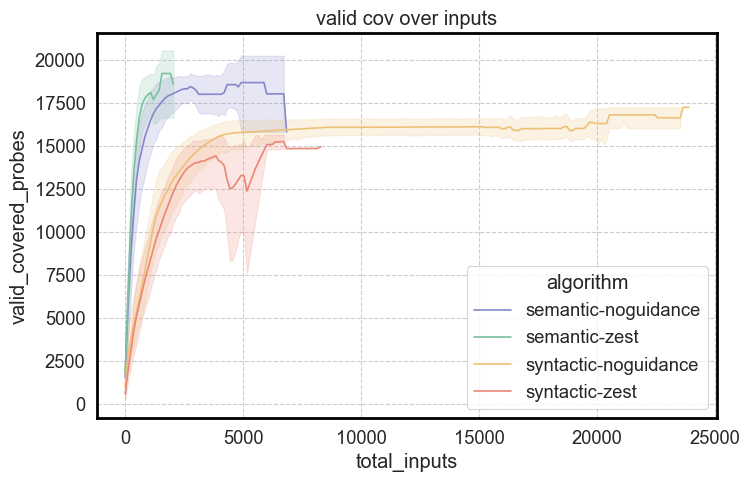

In [27]:

generate_plot_data_base(count_based_plot_data, rolling_time_based_plot_data, "total_inputs", "valid_covered_probes", f"{pdf_dir}valid_cov_over_inputs.pdf", 'ci')


In [28]:
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_inputs" , f"{pdf_dir}valid_inputs_over_time.pdf", errorbrar)

#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "invalid_inputs" , f"{pdf_dir}invalid_inputs_over_time.pdf", errorbrar)
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "all_covered_probes", f"{pdf_dir}all_cov_over_time.pdf", errorbrar)

#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "total_inputs" , f"{pdf_dir}inputs_over_time.pdf", errorbrar)
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_inputs", f"{pdf_dir}all_cov_over_time.pdf", errorbrar)

#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "unique_crashes", f"{pdf_dir}crashes_over_time.pdf", errorbrar)


In [29]:
#sns.pairplot(rolling_time_based_plot_data)

# unix_time valid_inputs_percent


C:\Users\Alena\AppData\Local\Temp\ipykernel_15812\2338042562.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


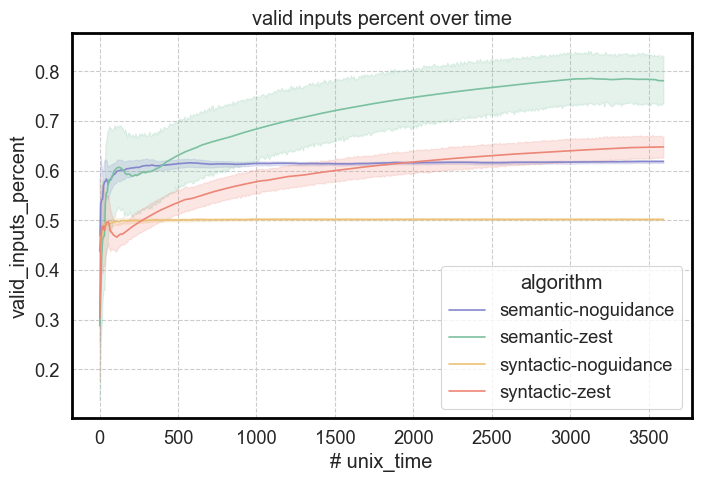

In [57]:

generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_inputs_percent", f"{pdf_dir}valid_inputs_percent_over_time.pdf", errorbrar)


In [31]:
exceptions_data[10:100]


,exception,unique,count,file,empty,algorithm,run
4,nextflow.exception.ScriptCompilationException,True,4.0,out1694884728304.nf,NaN,semantic-zest,3
0,nextflow.exception.AbortRunException,True,1.0,out1694886183368.nf,NaN,semantic-zest,4
1,nextflow.exception.ScriptCompilationException,True,1.0,out1694886217752.nf,NaN,semantic-zest,4
0,nextflow.exception.AbortRunException,True,1.0,out1694891053922.nf,NaN,semantic-zest,5
1,nextflow.exception.ScriptCompilationException,True,1.0,out1694891114813.nf,NaN,semantic-zest,5
...,...,...,...,...,...,...,...
38,nextflow.exception.ScriptCompilationException,True,7.0,out1694866719805.nf,NaN,syntactic-zest,0
39,groovy.lang.MissingPropertyException,True,31.0,out1694866720634.nf,NaN,syntactic-zest,0
40,groovy.lang.MissingPropertyException,True,32.0,out1694866721041.nf,NaN,syntactic-zest,0
41,nextflow.exception.ScriptCompilationException,True,8.0,out1694866721301.nf,NaN,syntactic-zest,0


In [32]:
for algo in ALGORITHM:
    algo_data = exceptions_data[exceptions_data['algorithm'] == algo]
    #print( algo)
    #print(algo_data['exception'].value_counts())
exceptions_count = exceptions_data.groupby(['exception','algorithm'])['algorithm'].count().to_frame()
print(exceptions_count)
#No such var - missing propertyexception
# no such method - groovy.lang.MissingMethodException
exceptions_count.T

                                                                    algorithm
exception                                     algorithm                      
No such variable                              afl                        1462
Script compilation error                      afl                       76792
Unknown method invocation `A`                 afl                          41
Unknown method invocation `G`                 afl                          41
groovy.lang.MissingPropertyException          semantic-noguidance           5
                                              syntactic-noguidance      32189
                                              syntactic-zest             3391
nextflow.exception.AbortRunException          semantic-noguidance          20
                                              semantic-zest                19
                                              syntactic-noguidance         20
                                              syntactic-zest    

exception No such variable Script compilation error  \
algorithm              afl                      afl   
algorithm             1462                    76792   

exception Unknown method invocation `A` Unknown method invocation `G`  \
algorithm                           afl                           afl   
algorithm                            41                            41   

exception groovy.lang.MissingPropertyException                       \
algorithm                  semantic-noguidance syntactic-noguidance   
algorithm                                    5                32189   

exception                nextflow.exception.AbortRunException                \
algorithm syntactic-zest                  semantic-noguidance semantic-zest   
algorithm           3391                                   20            19   

exception                                      \
algorithm syntactic-noguidance syntactic-zest   
algorithm                   20             20   

exception nextflow.exception.DuplicateProcessInvocation                 \
algorithm                          syntactic-noguidance syntactic-zest   
algorithm                                          2513            354   

exception nextflow.exception.ScriptCompilationException                \
algorithm                           semantic-noguidance semantic-zest   
algorithm                                           410            38   

exception                                      
algorithm syntactic-noguidance syntactic-zest  
algorithm                10471           1065

In [33]:
a =  exceptions_data.groupby(['exception','algorithm'])['algorithm'].count()
#pd.concat([group for name, group in a])
a

exception                                      algorithm           
No such variable                               afl                      1462
Script compilation error                       afl                     76792
Unknown method invocation `A`                  afl                        41
Unknown method invocation `G`                  afl                        41
groovy.lang.MissingPropertyException           semantic-noguidance         5
                                               syntactic-noguidance    32189
                                               syntactic-zest           3391
nextflow.exception.AbortRunException           semantic-noguidance        20
                                               semantic-zest              19
                                               syntactic-noguidance       20
                                               syntactic-zest             20
nextflow.exception.DuplicateProcessInvocation  syntactic-noguidance     2513
        

C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


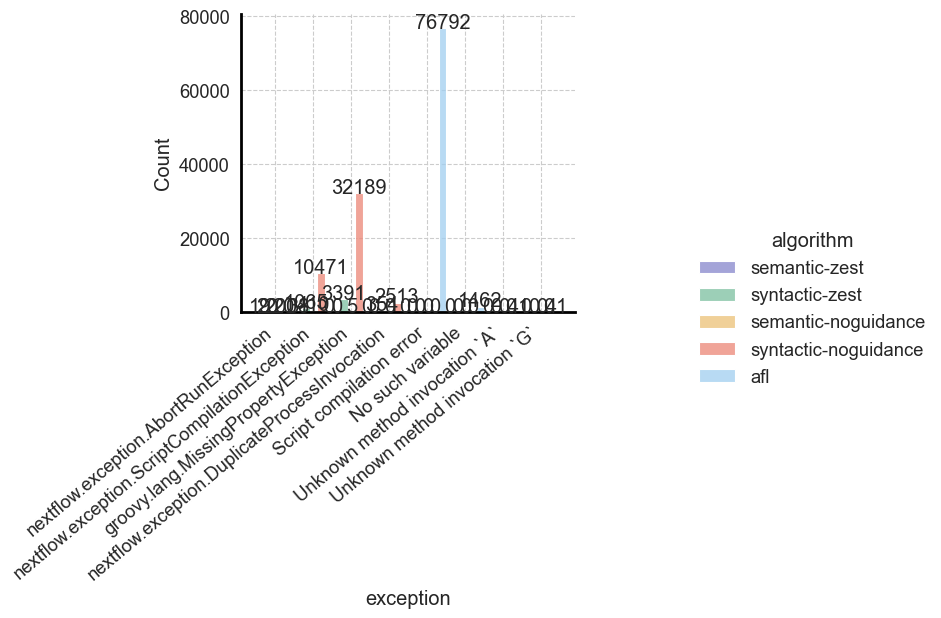

In [34]:
unique=exceptions_data[exceptions_data['unique'] == True]

plot=sns.displot(exceptions_data, x='exception',hue='algorithm', height=4, aspect=1.5, multiple="dodge")
plot.tight_layout()

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_ha('right')
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + 10
        value = str(int(p.get_height()))
        ax.text(_x, _y, value, ha="center")    


plot.savefig(f'{pdf_dir}/exceptions.pdf')

['semantic-noguidance', 'semantic-zest']
['syntactic-noguidance', 'syntactic-zest']


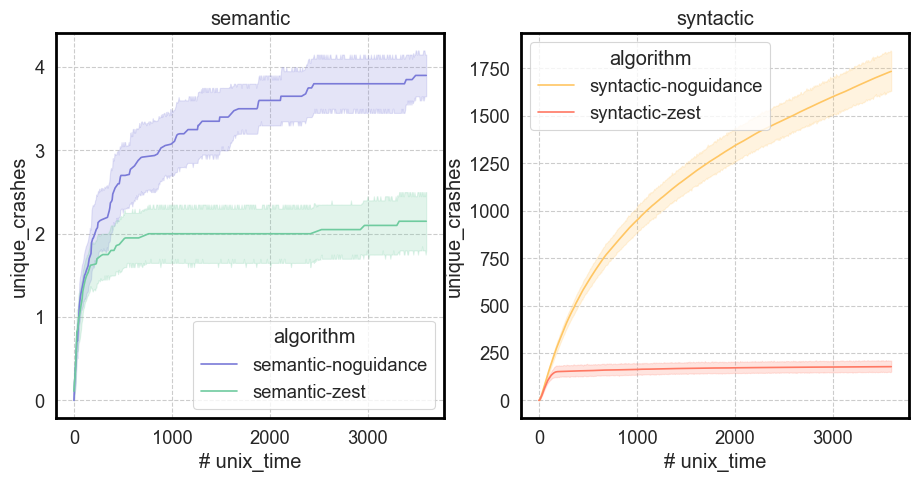

In [48]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(1,2, figsize=(11,5),sharey=False)
c=0
cols = sns.color_palette("husl",20)
for i, gen in enumerate(sorted(time_based_plot_data['generator'].unique())):
    unique= time_based_plot_data[time_based_plot_data['generator'] == gen]
    if i== 0:
        hues = sorted(ALGORITHM[:-1])[:-2]
        cols = colors[:-3]
    else:
        hues = sorted(ALGORITHM[:-1])[2:]
        cols = colors[2:-1]
    print(hues)
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='algorithm',
              hue_order= hues,
              errorbar='ci',
              ax=axes[i],
              palette=cols)
    #plot.get_legend().set_visible(False)
    plot.set_title(gen)

l.savefig(os.path.join( pdf_dir, "unique_crashes_per_generator.pdf" ), bbox_inches = 'tight', pad_inches = 0.1)

# unix_time unique_crashes


C:\Users\Alena\AppData\Local\Temp\ipykernel_15812\2338042562.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


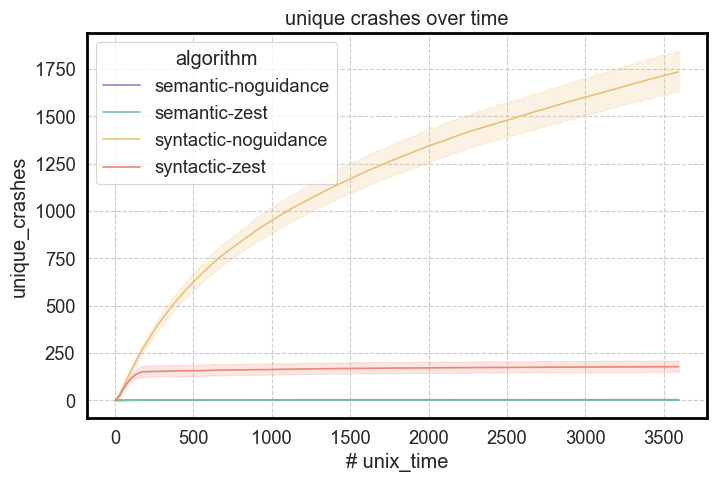

In [36]:
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "unique_crashes", f"{pdf_dir}unique_crashes_over_time.pdf", 'se')


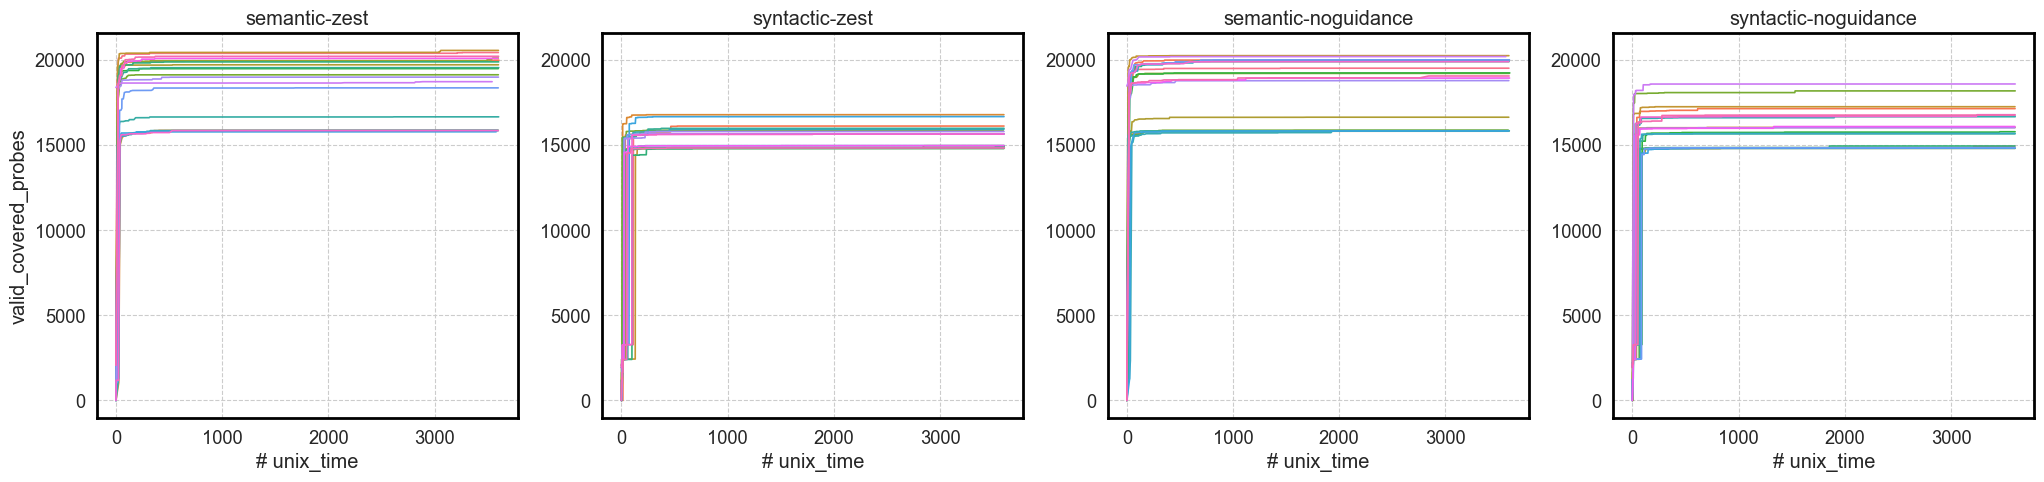

In [37]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(1,4, figsize=(25,5),sharey=True)
i=0
cols = sns.color_palette("husl",20)

for algo in ALGORITHM[:-1]:

    unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
    if not unique.empty: 
        plot = sns.lineplot(data=unique, 
                  x='# unix_time',
                  y='valid_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes[i],
                  palette=cols)
        plot.set_title(algo)
        plot.get_legend().set_visible(False)
    i+=1

for ax in l.axes:
    ax.tick_params(axis='y', labelleft=True)
    
l.savefig(os.path.join( pdf_dir, "cov_per_run.pdf" ))


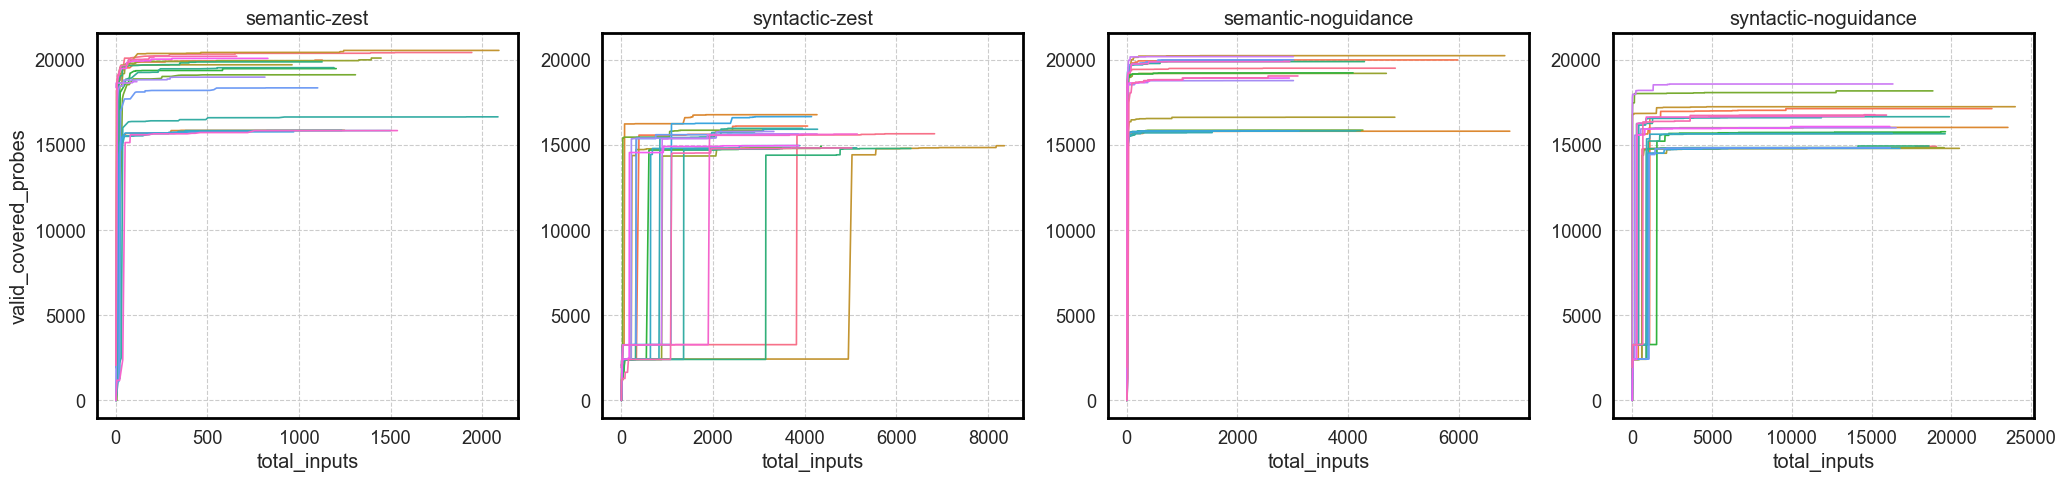

In [38]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(1,4, figsize=(25,5),sharey=True)
i=0
cols = sns.color_palette("husl",20)

for algo in ALGORITHM[:-1]:

    unique=rolling_count_based_plot_data[rolling_count_based_plot_data['algorithm'] == algo]
    if not unique.empty: 
        plot = sns.lineplot(data=unique, 
                  x='total_inputs',
                  y='valid_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes[i],
                  palette=cols)
        plot.set_title(algo)
        plot.get_legend().set_visible(False)
    i+=1

for ax in l.axes:
    ax.tick_params(axis='y', labelleft=True)
    
l.savefig(os.path.join( pdf_dir, "cov_per_run_over_inputs.pdf" ))


In [39]:
import scipy.stats as stats
# perform two-sided test. You can use 'greater' or 'less' for one-sided test
df1 = rolling_time_based_plot_data[rolling_time_based_plot_data['generator'] == 'semantic'].groupby(['run'])['valid_inputs_percent'].last()
#df1 = time_based_plot_data[time_based_plot_data['algorithm'].str.match('semantic')]['valid_inputs_percent']
df2 = rolling_time_based_plot_data[rolling_time_based_plot_data['generator']=='syntactic'].groupby(['run'])['valid_inputs_percent'].last()
#df2 = time_based_plot_data[time_based_plot_data['algorithm'].str.match('syntactic')]['valid_inputs_percent']

print(stats.mannwhitneyu(x=df1, y=df2))

print(df1.describe())
print(df2.describe())



MannwhitneyuResult(statistic=400.0, pvalue=6.79561512817336e-08)
count    20.000000
mean      0.618405
std       0.006623
min       0.598778
25%       0.616527
50%       0.618333
75%       0.622240
max       0.626812
Name: valid_inputs_percent, dtype: float64
count    20.000000
mean      0.501666
std       0.004076
min       0.490436
25%       0.500907
50%       0.501642
75%       0.504357
max       0.508450
Name: valid_inputs_percent, dtype: float64


### difference valid inputs percent generators

In [40]:
d = complete_data_frame

df1 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())


MannwhitneyuResult(statistic=400.0, pvalue=6.79561512817336e-08)
count    20.000000
mean      0.618405
std       0.006623
min       0.598778
25%       0.616527
50%       0.618333
75%       0.622240
max       0.626812
Name: valid_inputs_percent, dtype: float64
count    20.000000
mean      0.501666
std       0.004076
min       0.490436
25%       0.500907
50%       0.501642
75%       0.504357
max       0.508450
Name: valid_inputs_percent, dtype: float64


### difference valid covered probes generators

In [41]:

df1 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())

MannwhitneyuResult(statistic=326.0, pvalue=0.0006868221882035613)
count       20.000000
mean     18322.950000
std       1842.349286
min      15807.000000
25%      15861.250000
50%      19125.500000
75%      19905.500000
max      20242.000000
Name: valid_covered_probes, dtype: float64
count       20.000000
mean     16118.950000
std       1128.294077
min      14799.000000
25%      14932.250000
50%      16019.500000
75%      16759.750000
max      18580.000000
Name: valid_covered_probes, dtype: float64


### difference valid inputs percent guided vs blackbox

In [42]:
d = complete_data_frame

df1 = d[d['algorithm'].str.match('semantic-zest')].groupby(['run'])['valid_inputs_percent'].last()
df2 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())


df1 = d[d['algorithm'].str.match('syntactic-zest')].groupby(['run'])['valid_inputs_percent'].last()
df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())


MannwhitneyuResult(statistic=380.0, pvalue=1.2008881938423432e-06)
count    20.000000
mean      0.782203
std       0.113751
min       0.575050
25%       0.707528
50%       0.751202
75%       0.891801
max       1.000000
Name: valid_inputs_percent, dtype: float64
count    20.000000
mean      0.618405
std       0.006623
min       0.598778
25%       0.616527
50%       0.618333
75%       0.622240
max       0.626812
Name: valid_inputs_percent, dtype: float64
MannwhitneyuResult(statistic=400.0, pvalue=6.79561512817336e-08)
count    20.000000
mean      0.647773
std       0.051106
min       0.548765
25%       0.612225
50%       0.653175
75%       0.675712
max       0.741210
Name: valid_inputs_percent, dtype: float64
count    20.000000
mean      0.501666
std       0.004076
min       0.490436
25%       0.500907
50%       0.501642
75%       0.504357
max       0.508450
Name: valid_inputs_percent, dtype: float64


### difference valid coverage guided vs blackbox

In [49]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100


In [50]:

d = complete_data_frame
df1 = d[d['algorithm'].str.match('semantic-zest')].groupby(['run'])['valid_covered_probes'].last()
df2 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())
print(cv(df1))
print(cv(df2))

df1 = d[d['algorithm'].str.match('syntactic-zest')].groupby(['run'])['valid_covered_probes'].last()
df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())
print(cv(df1))
print(cv(df2))

MannwhitneyuResult(statistic=222.0, pvalue=0.5608333167888789)
count       20.000000
mean     18546.850000
std       1821.865911
min      15773.000000
25%      16452.250000
50%      19301.000000
75%      20003.250000
max      20550.000000
Name: valid_covered_probes, dtype: float64
count       20.000000
mean     18322.950000
std       1842.349286
min      15807.000000
25%      15861.250000
50%      19125.500000
75%      19905.500000
max      20242.000000
Name: valid_covered_probes, dtype: float64
9.823047638380203
10.054872638578496
MannwhitneyuResult(statistic=131.0, pvalue=0.06389223492711604)
count       20.000000
mean     15476.600000
std        634.373159
min      14793.000000
25%      14896.500000
50%      15638.500000
75%      15880.750000
max      16777.000000
Name: valid_covered_probes, dtype: float64
count       20.000000
mean     16118.950000
std       1128.294077
min      14799.000000
25%      14932.250000
50%      16019.500000
75%      16759.750000
max      18580.000000
Nam

In [51]:
d=complete_data_frame
a = d[d['algorithm'].str.match('semantic-noguidance')]
b = d[d['algorithm'].str.match('syntactic-noguidance')]

c = d[d['algorithm'].str.match('semantic-zest')]
e = d[d['algorithm'].str.match('syntactic-zest')]

print(a['valid_inputs_percent'].std()) 
print(a.groupby(['run'])['valid_inputs_percent'].last().describe()) 


print(b['valid_inputs_percent'].std())
print(b.groupby(['run'])['valid_inputs_percent'].last().describe())






0.028079586488259593
count    20.000000
mean      0.618405
std       0.006623
min       0.598778
25%       0.616527
50%       0.618333
75%       0.622240
max       0.626812
Name: valid_inputs_percent, dtype: float64
0.013373043206289152
count    20.000000
mean      0.501666
std       0.004076
min       0.490436
25%       0.500907
50%       0.501642
75%       0.504357
max       0.508450
Name: valid_inputs_percent, dtype: float64


In [52]:
d= complete_data_frame
d[d['algorithm'].str.match('syntactic-noguidance')]['valid_inputs_percent'].std()


0.013373043206289152

In [53]:
for algo in ALGORITHM:
    b =complete_data_frame[complete_data_frame['algorithm'].str.match(algo)]

    total = b.groupby(['run'])['total_inputs'].last()
    val = b.groupby(['run'])['valid_inputs'].last() 
    valper = b.groupby(['run'])['valid_inputs_percent'].last()

    total_mean  = total.mean()
    val_mean= val.mean()
    valper_mean = valper.mean()

    total_std = cv(total)
    val_std = cv(val)
    valper_std = cv(valper)
    
    print(f"{algo} & {total_mean:.0f} ({total_std:.2f}\%) &  {val_mean:.0f} ({val_std:.2f}\%) & {valper_mean*100:.2f} ({valper_std:.2f}\%) ")
    
    


semantic-zest & 1225 (38.76\%) &  922 (33.62\%) & 78.22 (14.54\%) 
syntactic-zest & 4619 (27.26\%) &  2947 (20.52\%) & 64.78 (7.89\%) 
semantic-noguidance & 4091 (31.87\%) &  2532 (32.03\%) & 61.84 (1.07\%) 
syntactic-noguidance & 18550 (14.28\%) &  9307 (14.41\%) & 50.17 (0.81\%) 
afl & nan (nan\%) &  nan (nan\%) & nan (nan\%) 


In [54]:
d = complete_data_frame
for algo in ALGORITHM:
    b = d[d['algorithm'].str.match(algo)]
    total = b.groupby(['run'])['all_covered_probes'].last()
    val = b.groupby(['run'])['valid_covered_probes'].last() 
   
    total_mean  = total.mean()
    val_mean= val.mean()
 

    total_std = cv(total)
    val_std = cv(val)
   
    
    print(f"{algo} &   {val_mean:.2f} ({val_std:.2f}\%) ")
    
    


semantic-zest &   18546.85 (9.82\%) 
syntactic-zest &   15476.60 (4.10\%) 
semantic-noguidance &   18322.95 (10.05\%) 
syntactic-noguidance &   16118.95 (7.00\%) 
afl &   nan (nan\%) 


In [55]:
data = complete_data_frame[complete_data_frame['algorithm']=='semantic-zest']
print(data.groupby(['run','algorithm'])['total_inputs'].max())


run  algorithm    
0    semantic-zest    1943.0
1    semantic-zest    1127.0
2    semantic-zest    1248.0
3    semantic-zest    2091.0
4    semantic-zest     962.0
5    semantic-zest    1448.0
6    semantic-zest    1308.0
7    semantic-zest    1203.0
8    semantic-zest    1126.0
9    semantic-zest    1191.0
10   semantic-zest    2086.0
11   semantic-zest    1234.0
12   semantic-zest    1499.0
13   semantic-zest     971.0
14   semantic-zest    1102.0
15   semantic-zest     814.0
16   semantic-zest     115.0
17   semantic-zest     830.0
18   semantic-zest    1537.0
19   semantic-zest     660.0
Name: total_inputs, dtype: float64


<Axes: xlabel='# unix_time', ylabel='map_size'>

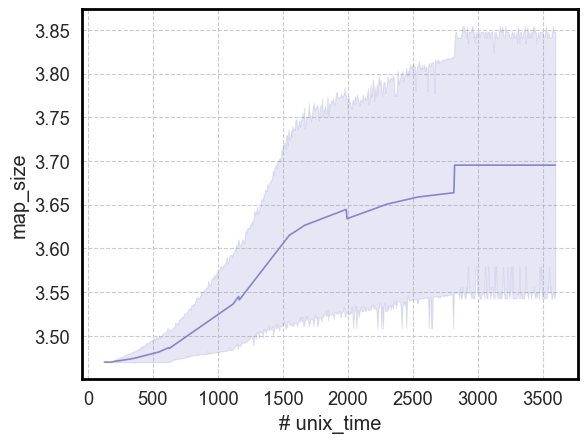

In [56]:
sns.lineplot(data=afl_time_based_plot_data, x='# unix_time', y='map_size')